<a href="https://colab.research.google.com/github/fromrang/data-analysis/blob/master/analysis_practice/wine_data_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
print(red.head())
print(white.head())


   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]
   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.0              0.27         0.36  ...       0.45      8.8        6
1            6.3              0.30         0.34  ...       0.49      9.5        6
2            8.1              0.28         0.40  ...       0.44     10.1        6
3            7.2              0.23         0.32  ...       0.40      9.9        6
4            7.2              0.23         0.32  ...       0.40      9.9   

## **red 와인은 type 0으로 white 와인은 type 1로 지정해준 다음 두 데이터프레임을 합친다.**

In [4]:
red['type'] = 0
white['type'] = 1

wine = pd.concat([red,white])
print(wine)

      fixed acidity  volatile acidity  citric acid  ...  alcohol  quality  type
0               7.4              0.70         0.00  ...      9.4        5     0
1               7.8              0.88         0.00  ...      9.8        5     0
2               7.8              0.76         0.04  ...      9.8        5     0
3              11.2              0.28         0.56  ...      9.8        6     0
4               7.4              0.70         0.00  ...      9.4        5     0
...             ...               ...          ...  ...      ...      ...   ...
4893            6.2              0.21         0.29  ...     11.2        6     1
4894            6.6              0.32         0.36  ...      9.6        5     1
4895            6.5              0.24         0.19  ...      9.4        6     1
4896            5.5              0.29         0.30  ...     12.8        7     1
4897            6.0              0.21         0.38  ...     11.8        6     1

[6497 rows x 13 columns]


## **그래프와 텍스트로 데이터가 잘 구성되어있는 지 확인한다.**

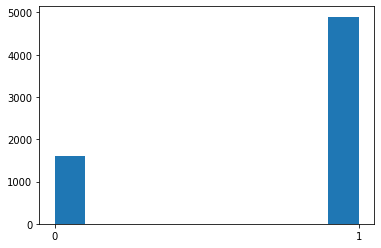

type data:  [0 1]


In [28]:
plt.hist(wine['type'])
plt.xticks([0, 1])
plt.show()

print("type data: ",np.unique(wine['type']))

## **x에는 속성값을 y에는 타깃값을 넣어준다**

In [31]:
x = wine.iloc[:,0:-1]
y = wine.iloc[:,-1]

## **사이킷런을 사용해서 속성(x) 데이터를 표준화시켜준다.**

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x)
x_std = sc.transform(x)
print(x_std)

[[ 0.14247327  2.18883292 -2.19283252 ...  0.19309677 -0.91546416
  -0.93722961]
 [ 0.45103572  3.28223494 -2.19283252 ...  0.99957862 -0.58006813
  -0.93722961]
 [ 0.45103572  2.55330026 -1.91755268 ...  0.79795816 -0.58006813
  -0.93722961]
 ...
 [-0.55179227 -0.6054167  -0.88525328 ... -0.47897144 -0.91546416
   0.20799905]
 [-1.32319841 -0.30169391 -0.12823371 ... -1.016626    1.9354021
   1.35322771]
 [-0.93749534 -0.78765037  0.42232597 ... -1.41986693  1.09691202
   0.20799905]]


## **사이킷런에 train_test_split 클래스를 사용해서 test 데이터와 train 데이터를 나눈다.**  
test 데이터를 30%, train 데이터를 70%로 구성되게 나누어 주고, 
stratify 파라미터를 사용해서 y 값이 균일하게 나누어질 수 있도록 해준다.
(random_state 파라미터를 통해 데이터를 섞을 수 있다.) 

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = 0.3, random_state = 1, stratify = y )

In [33]:
print('total amount of y: ', np.bincount(y))
print('amount of y train data: ', np.bincount(y_train))
print('amount of y test data: ', np.bincount(y_test))

total amount of y:  [1599 4898]
amount of y train data:  [1119 3428]
amount of y test data:  [ 480 1470]


## **모델을 정의한다.**  
red와 white로 출력결과가 두개이기 때문에 마지막 layer에 units를 2로 지정하고 sigmoid 함수를 사용할 수 있도록 지정하였다.

In [19]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=48, activation = 'relu', input_shape = (12,)),
                             tf.keras.layers.Dense(units=24, activation = 'relu'),
                             tf.keras.layers.Dense(units=12, activation = 'relu'),
                             tf.keras.layers.Dense(units=2, activation = 'sigmoid'),
])

## **모델 최적화를 해준다**
모델 최적화에서는 학습률과 손실 함수를 지정해주면 된다.  
척도(metrics)로는 정확도를 지정해주었다.

In [34]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
for layer_ in model.layers:
    print(layer_)
    print(layer_.get_output_at(0).get_shape().as_list())

[None, 48]
[None, 24]
[None, 12]
[None, 2]


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 48)                624       
                                                                 
 dense_5 (Dense)             (None, 24)                1176      
                                                                 
 dense_6 (Dense)             (None, 12)                300       
                                                                 
 dense_7 (Dense)             (None, 2)                 26        
                                                                 
Total params: 2,126
Trainable params: 2,126
Non-trainable params: 0
_________________________________________________________________


## **실제 데이터로 훈련을 진행하고 진행내역을 객체에 기록한다.**

In [37]:
history = model.fit(x_train, y_train, epochs=25, batch_size= 32, validation_split=0.25)

Epoch 1/25
107/107 [==============================] - 1s 4ms/step - loss: 0.0555 - accuracy: 0.9909 - val_loss: 0.0283 - val_accuracy: 0.9965
Epoch 2/25
107/107 [==============================] - 0s 3ms/step - loss: 0.0538 - accuracy: 0.9909 - val_loss: 0.0314 - val_accuracy: 0.9965
Epoch 3/25
107/107 [==============================] - 0s 3ms/step - loss: 0.0534 - accuracy: 0.9909 - val_loss: 0.0301 - val_accuracy: 0.9965
Epoch 4/25
107/107 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 0.9909 - val_loss: 0.0284 - val_accuracy: 0.9965
Epoch 5/25
107/107 [==============================] - 0s 3ms/step - loss: 0.0540 - accuracy: 0.9909 - val_loss: 0.0288 - val_accuracy: 0.9965
Epoch 6/25
107/107 [==============================] - 0s 3ms/step - loss: 0.0530 - accuracy: 0.9909 - val_loss: 0.0291 - val_accuracy: 0.9965
Epoch 7/25
107/107 [==============================] - 0s 3ms/step - loss: 0.0546 - accuracy: 0.9909 - val_loss: 0.0311 - val_accuracy: 0.9965
Epoch 

## **예측값을 확인하고 손실도와 정확도를 확인한다.**


In [39]:
pred_y = model.predict(x_test)
print('prediction: ',pred_y)
print(model.evaluate(x_test, y_test))

61/61 [==============================] - 0s 1ms/step - loss: 0.0572 - accuracy: 0.9897
[0.05717579275369644, 0.9897435903549194]


In [24]:
print(pred_y)

[[0.07648656 0.92351365]
 [0.07648656 0.92351365]
 [0.07648656 0.92351365]
 ...
 [0.07648656 0.92351365]
 [0.07648656 0.92351365]
 [0.9207884  0.15573058]]
